# News classification with topic models in gensim
News article classification is a task which is performed on a huge scale by news agencies all over the world. We will be looking into how topic modeling can be used to accurately classify news articles into different categories such as sports, technology, politics etc.

Our aim in this tutorial is to come up with some topic model which can come up with topics that can easily be interpreted by us. Such a topic model can be used to discover hidden structure in the corpus and can also be used to determine the membership of a news article into one of the topics.

For this tutorial, we will be using the Lee corpus which is a shortened version of the [Lee Background Corpus](http://www.socsci.uci.edu/~mdlee/lee_pincombe_welsh_document.PDF). The shortened version consists of 300 documents selected from the Australian Broadcasting Corporation's news mail service. It consists of texts of headline stories from around the year 2000-2001.

Accompanying slides can be found [here](https://speakerdeck.com/dsquareindia/pycon-delhi-lightening).

### Requirements
In this tutorial we look at how different topic models can be easily created using [gensim](https://radimrehurek.com/gensim/).
Following are the dependencies for this tutorial:
    - Gensim Version >=0.13.1 would be preferred since we will be using topic coherence metrics extensively here.
    - matplotlib
    - nltk.stopwords and nltk.wordnet
    - pyLDAVis
We will be playing around with 4 different topic models here:
    - LSI (Latent Semantic Indexing)
    - HDP (Hierarchical Dirichlet Process)
    - LDA (Latent Dirichlet Allocation)
    - LDA (tweaked with topic coherence to find optimal number of topics) and
    - LDA as LSI with the help of topic coherence metrics
First we'll fit those topic models on our existing data then we'll compare each against the other and see how they rank in terms of human interpretability.

All can be found in gensim and can be easily used in a plug-and-play fashion. We will tinker with the LDA model using the newly added topic coherence metrics in gensim based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al and see how the resulting topic model compares with the exsisting ones.

In [51]:
import os
import re
import operator
import matplotlib.pyplot as plt
import warnings
import gensim
import numpy as np
warnings.filterwarnings('ignore')  # Let's not pay heed to them right now

import nltk
nltk.download('stopwords') # Let's make sure the 'stopword' package is downloaded & updated
nltk.download('wordnet') # Let's also download wordnet, which will be used for lemmatization

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from pprint import pprint

import numpy as np
import pandas as pd

%matplotlib inline

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [65]:
# df = pd.read_csv('../data/rss_feeds_new.csv')
# df = df[pd.notnull(df['processed_text'])]
# text = df['processed_text'].values.tolist()

df = pd.read_csv('../data/rss_feeds_new.csv')
df = df[pd.notnull(df['article_text'])]
text = df['article_text'].values.tolist()

In [54]:
def build_texts(text):
    """
    Function to build tokenized texts from file
    
    Parameters:
    ----------
    fname: File to be read
    
    Returns:
    -------
    yields preprocessed line
    """
    for line in text:
        yield gensim.utils.simple_preprocess(line, deacc=True, min_len=3)

In [55]:
train_texts = list(build_texts(text))

In [56]:
len(train_texts)

3551

The following gets a summary of the article that is inserted

In [271]:
from gensim.summarization import summarize
from gensim.summarization import keywords

In [288]:
def get_summary(text):
    summary = summarize(text, ratio=0.01)
#     keyword = keywords(text, ratio=0.01)
    
    return summary

In [295]:
summary = []
keywords = []
for article in df['article_text']:
    try:
        temp = get_summary(str(article))
        summary.append(temp)
#     keywords.append(temp[1])
    except:
        pass
print(summary[0])

### Preprocessing our data. Remember: Garbage In Garbage Out
                                        "NLP is 80% preprocessing."
                                                                -Lev Konstantinovskiy
This is the single most important step in setting up a good topic modeling system. If the preprocessing is not good, the algorithm can't do much since we would be feeding it a lot of noise. In this tutorial, we will be filtering out the noise using the following steps in this order for each line:
1. Stopword removal using NLTK's english stopwords dataset.
2. Bigram collocation detection (frequently co-occuring tokens) using gensim's [Phrases](https://radimrehurek.com/gensim/models/phrases.html). This is our first attempt to find some hidden structure in the corpus. You can even try trigram collocation detection.
3. Lemmatization (using gensim's [`lemmatize`](https://radimrehurek.com/gensim/utils.html#gensim.utils.lemmatize)) to only keep the nouns. Lemmatization is generally better than stemming in the case of topic modeling since the words after lemmatization still remain understable. However, generally stemming might be preferred if the data is being fed into a vectorizer and isn't intended to be viewed.

In [57]:
bigram = gensim.models.Phrases(train_texts)  # for bigram collocation detection

In [58]:
bigram[['new', 'york', 'example']]

['new_york', 'example']

In [59]:
from gensim.utils import lemmatize
from nltk.corpus import stopwords

In [76]:
stops = set(stopwords.words('english'))  # nltk stopwords list
words_to_remove = ['http', 'com', '_', '__', '___']

In [90]:
def process_texts(article_text):
    """
    Function to process texts. Following are the steps we take:
    
    1. Stopword Removal.
    2. Collocation detection.
    3. Lemmatization (not stem since stemming can reduce the interpretability).
    
    Parameters:
    ----------
    texts: Tokenized texts.
    
    Returns:
    -------
    texts: Pre-processed tokenized texts.
    """
#     article_text = [[word for word in line if word not in stops] for line in article_text]
    
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    quotes1 = ' '.join(re.findall('“.*?”', article_text))
    quotes2 = ' '.join(re.findall('".*?"', article_text))
    quotes = quotes1 + quotes2

    tweets = ' '.join(re.findall('\n\n.*?@', article_text))+' '+' '.join(re.findall('\n\n@.*?@', article_text))

    article_text = re.sub('\n\n.*?@', '', article_text)
    article_text = re.sub('\n\n@.*?@', '', article_text)
    # Remove tweet
    article_text = ' '.join([word for word in article_text.split(' ') if not word.startswith('(@') and not word.startswith('http')])

    article_text = re.sub('“.*?”', '', article_text)
    article_text = re.sub('".*?"', '', article_text)

    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    sw = set(stopwords.words('english'))
    wordnet = WordNetLemmatizer()

    article_text = article_text.lower()
    quotes = quotes.lower()
    tweets = tweets.lower()

    article_text_tokens = tokenizer.tokenize(article_text)
    quotes_tokens = tokenizer.tokenize(quotes)
    tweets_tokens = tokenizer.tokenize(tweets)

    # remove stop words, unwanted words, tweet handles, links from tokens
    article_text_stopped_tokens = [i for i in article_text_tokens if i not in sw and i not in words_to_remove]
    quotes_stopped_tokens = [i for i in quotes_tokens if not i in sw and i not in words_to_remove]
    tweets_stopped_tokens = [i for i in tweets_tokens if not i in sw and i not in words_to_remove]

    article_text_stopped_tokens = bigram[article_text_stopped_tokens]
    quotes_stopped_tokens = bigram[quotes_stopped_tokens]
    tweets_stopped_tokens = bigram[tweets_stopped_tokens]
    
    # stem token
    article_text = [wordnet.lemmatize(i) for i in article_text_stopped_tokens]
    quotes = [wordnet.lemmatize(i) for i in quotes_stopped_tokens]
    tweets = [wordnet.lemmatize(i) for i in tweets_stopped_tokens]

    return article_text, quotes, tweets

In [93]:
train_texts = []
for article in text:
    temp = process_texts(article)
    train_texts.append(temp[0] + temp[1] + temp[2])
train_texts[5:6]

[['latino',
  'several',
  'big',
  'cities_across',
  'country',
  'appear',
  'reporting',
  'fewer',
  'crime',
  'year',
  'last',
  'pattern',
  'experts_say',
  'could',
  'evidence',
  'president',
  'trump',
  'tough',
  'stance',
  'immigration',
  'sowing',
  'mistrust',
  'law_enforcement',
  'officer',
  'among',
  'immigrant',
  'family',
  'recent_months',
  'police_chief',
  'los_angeles',
  'houston',
  'said',
  'report',
  'latino',
  'certain',
  'type',
  'crime',
  'respective',
  'city',
  'chief',
  'blamed',
  'decline',
  'heightened',
  'fear',
  'deportation',
  'among',
  'undocumented_immigrants',
  'majority',
  'latino',
  'say',
  'trend',
  'concerning',
  'police_department',
  'rely',
  'member',
  'community',
  'regardless',
  'legal_status',
  'report',
  'crime',
  'occur',
  'houston',
  'police_chief',
  'art',
  'acevedo',
  'said',
  'press_conference',
  'last_month',
  'according',
  'houston_chronicle',
  'u',
  'latino',
  'course',
  'imm

Finalising our dictionary and corpus

In [114]:
dictionary = Dictionary(train_texts)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in train_texts]

### Topic modeling with LSI
This is a useful topic modeling algorithm in that it can rank topics by itself. Thus it outputs topics in a ranked order. However it does require a `num_topics` parameter (set to 200 by default) to determine the number of latent dimensions after the SVD.

In [16]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [17]:
lsimodel.show_topics(num_topics=5)  # Showing only the top 5 topics

[(0,
  '0.654*"trump" + 0.360*"said" + 0.221*"president" + 0.152*"would" + 0.121*"story" + 0.115*"one" + 0.114*"republican" + 0.106*"also" + 0.105*"white_house" + 0.097*"advertisement_continue"'),
 (1,
  '0.583*"trump" + -0.379*"said" + -0.313*"story" + -0.307*"advertisement_continue" + -0.305*"reading_main" + -0.134*"would" + -0.130*"state" + 0.113*"president" + -0.073*"bill" + -0.072*"people"'),
 (2,
  '-0.341*"reading_main" + -0.337*"advertisement_continue" + -0.334*"story" + -0.240*"trump" + 0.212*"state" + 0.209*"would" + 0.159*"republican" + 0.152*"people" + -0.141*"said" + 0.127*"one"'),
 (3,
  '-0.699*"said" + 0.299*"story" + 0.282*"advertisement_continue" + 0.280*"reading_main" + 0.100*"natesilver" + 0.093*"micah" + 0.085*"would" + 0.084*"republican" + 0.081*"think" + 0.077*"trump"'),
 (4,
  '-0.428*"republican" + -0.243*"democrat" + 0.198*"country" + 0.196*"president" + -0.194*"house" + -0.178*"state" + -0.154*"gianforte" + 0.150*"united_state" + 0.129*"american" + -0.127*"el

In [18]:
lsitopics = lsimodel.show_topics(formatted=False)

### Topic modeling with [HDP](http://jmlr.csail.mit.edu/proceedings/papers/v15/wang11a/wang11a.pdf)
An HDP model is fully unsupervised. It can also determine the ideal number of topics it needs through posterior inference.

In [19]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [20]:
hdpmodel.show_topics()

[(0,
  '0.019*trump + 0.015*said + 0.008*president + 0.005*would + 0.004*also + 0.004*white_house + 0.004*republican + 0.004*one + 0.004*story + 0.003*may + 0.003*state + 0.003*time + 0.003*advertisement_continue + 0.003*official + 0.003*reading_main + 0.003*say + 0.003*could + 0.002*people + 0.002*campaign + 0.002*new'),
 (1,
  '0.014*trump + 0.012*said + 0.005*president + 0.004*would + 0.004*one + 0.004*also + 0.003*republican + 0.003*may + 0.003*state + 0.003*story + 0.003*say + 0.003*democrat + 0.003*time + 0.003*people + 0.003*advertisement_continue + 0.002*could + 0.002*reading_main + 0.002*election + 0.002*percent + 0.002*white_house'),
 (2,
  '0.011*trump + 0.009*said + 0.005*story + 0.005*advertisement_continue + 0.005*president + 0.005*reading_main + 0.004*would + 0.002*one + 0.002*may + 0.002*official + 0.002*also + 0.002*white_house + 0.002*united_state + 0.002*report + 0.002*could + 0.002*time + 0.002*american + 0.002*campaign + 0.002*city + 0.001*republican'),
 (3,
  '0.0

In [21]:
hdptopics = hdpmodel.show_topics(formatted=False)

### Topic modeling using [LDA](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei. Let's choose 10 topics to initialize this.

In [115]:
chunksize = 10000
passes = 20         # Was 20
iterations = 400     # Was 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

ldamodel = LdaModel(corpus=corpus, num_topics=40, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)

pyLDAvis is a great way to visualize an LDA model. To summarize in short, the area of the circles represent the prevelance of the topic. The length of the bars on the right represent the membership of a term in a particular topic. pyLDAvis is based on [this](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) paper.

In [116]:
import pyLDAvis.gensim

In [117]:
pyLDAvis.enable_notebook()

In [118]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
20     6.394611        1       1  0.001780 -0.061996
16     6.239388        1       2  0.078126  0.078330
2      5.376198        1       3  0.033976 -0.039251
25     5.291870        1       4  0.003585  0.030548
18     4.840313        1       5 -0.033440 -0.018032
19     4.753580        1       6 -0.148016  0.075870
0      4.426700        1       7  0.111930  0.059904
14     4.063379        1       8 -0.196488 -0.000687
23     3.882631        1       9  0.112152  0.143035
12     3.691143        1      10  0.088520 -0.049806
13     3.339603        1      11  0.003750 -0.109333
17     3.208821        1      12  0.039447  0.022901
27     3.203114        1      13  0.069097  0.112296
6      3.069318        1      14  0.016500 -0.050087
5      2.995188        1      15  0.021088 -0.001770
22     2.930422        1      16 -0.198197  0.061955
15     2.599779        1      17  0.063965  0.015562
35     2.495639        1      18  0.095642  0.067823
7      2.302912        1      19 -0.127572  0.045303
3      2.261912        1      20  0.033771 -0.161159
31     1.794024        1      21 -0.153567 -0.001224
26     1.751919        1      22  0.010944 -0.097618
28     1.665334        1      23 -0.003131 -0.063269
21     1.598278        1      24  0.038554  0.080741
24     1.565044        1      25 -0.002021 -0.005515
37     1.551519        1      26 -0.020651  0.066141
29     1.536154        1      27  0.031823 -0.021857
30     1.315500        1      28 -0.029018 -0.096494
36     1.196675        1      29  0.023857 -0.034423
39     1.027235        1      30  0.025167  0.048544
34     0.994557        1      31 -0.135513  0.056167
33     0.961239        1      32  0.014745  0.038731
1      0.946439        1      33  0.058012  0.015361
11     0.934350        1      34  0.013685 -0.016921
8      0.910651        1      35 -0.003651 -0.072778
32     0.864147        1      36  0.013488 -0.059758
38     0.554089        1      37  0.017103  0.007915
9      0.526063        1      38  0.015496 -0.040644
4      0.506301        1      39  0.005791 -0.017514
10     0.433959        1      40  0.009272 -0.006993, topic_info=     Category         Freq                    Term        Total  loglift  \
term                                                                       
3499  Default  6885.000000                      mr  6885.000000  30.0000   
6171  Default  2537.000000              main_story  2537.000000  29.0000   
4748  Default  2497.000000  advertisement_continue  2497.000000  28.0000   
4749  Default  2601.000000                 reading  2601.000000  27.0000   
317   Default  2214.000000                 percent  2214.000000  26.0000   
1789  Default   949.000000                   flynn   949.000000  25.0000   
421   Default  1728.000000                   comey  1728.000000  24.0000   
2572  Default   844.000000               gianforte   844.000000  23.0000   
560   Default  1343.000000                  budget  1343.000000  22.0000   
3172  Default   790.000000                 kushner   790.000000  21.0000   
831   Default  1784.000000                  russia  1784.000000  20.0000   
5     Default  1628.000000                    bill  1628.000000  19.0000   
450   Default  3388.000000             white_house  3388.000000  18.0000   
127   Default  3287.000000                   state  3287.000000  17.0000   
103   Default  3163.000000              republican  3163.000000  16.0000   
847   Default  2006.000000           investigation  2006.000000  15.0000   
974   Default  1585.000000               committee  1585.000000  14.0000   
3259  Default  1172.000000                 russian  1172.000000  13.0000   
3300  Default   536.000000                  israel   536.000000  12.0000   
150   Default  2098.000000                democrat  2098.000000  11.0000   
7     Default  1774.000000                   house  1774.00

In [135]:
ldatopics = ldamodel.show_topics(num_topics=40,formatted=False)

In [141]:
ldamodel.show_topics(40)
df['url'][0]

'https://fivethirtyeight.com/features/are-moderate-republicans-really-willing-to-kill-the-senate-health-care-bill/'

### Finding out the optimal number of topics
__Introduction to topic coherence__:
<img src="https://rare-technologies.com/wp-content/uploads/2016/06/pipeline.png">
Topic coherence in essence measures the human interpretability of a topic model. Traditionally [perplexity has been used](http://qpleple.com/perplexity-to-evaluate-topic-models/) to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases. Here's a short blog I wrote explaining topic coherence:
[What is topic coherence?](https://rare-technologies.com/what-is-topic-coherence/)

In [104]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    chunksize = 10000
    passes = 1         # Was 20
    iterations = 50     # Was 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    
    c_v = []
    lm_list = []
    for num_topics in range(5, limit+1, 5):
        print(num_topics)
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    try:
        # Show graph
        x = range(1, len(c_v)+1)
        labels = range(5, limit+1, 5)
        plt.plot(x, c_v)
        plt.xticks(x, labels)
        plt.xlabel("num_topics")
        plt.ylabel("Coherence score")
        plt.legend(("c_v"), loc='best')
        plt.show()
    except:
        pass
    
    return lm_list, c_v

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80


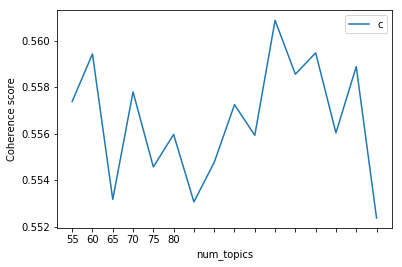

CPU times: user 19min 38s, sys: 23min 34s, total: 43min 12s
Wall time: 22min 13s


In [105]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=train_texts, limit=80)

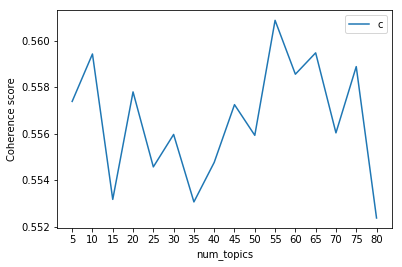

In [106]:
limit = 80
x = range(1, len(c_v)+1)
labels = range(5, limit+1, 5)
plt.plot(x, c_v)
plt.xticks(x, labels)
plt.xlabel("num_topics")
plt.ylabel("Coherence score")
plt.legend(("c_v"), loc='best')
plt.show()

In [107]:
pyLDAvis.gensim.prepare(lmlist[10], corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
53     11.993284        1       1 -0.019684 -0.006217
16      7.118914        1       2 -0.010358 -0.011655
48      5.091387        1       3 -0.020683  0.000718
1       4.622108        1       4 -0.027169  0.001095
20      3.772841        1       5 -0.015850 -0.013362
10      3.664869        1       6 -0.026586  0.007533
18      3.213882        1       7 -0.004500 -0.010977
21      3.189847        1       8 -0.018935  0.017991
30      3.034945        1       9 -0.002728 -0.008692
25      2.798579        1      10 -0.004466 -0.005437
3       2.633842        1      11 -0.026327  0.007751
32      2.594313        1      12 -0.020211 -0.010590
24      2.469689        1      13  0.021256 -0.022633
9       2.315955        1      14 -0.012921 -0.007088
8       2.292694        1      15 -0.013162  0.000689
12      2.250567        1      16  0.014693 -0.025044
43      2.228563        1      17 -0.014668  0.011012
0       2.126463        1      18 -0.005729 -0.001179
28      2.068961        1      19 -0.003681 -0.000863
26      2.040084        1      20 -0.009993  0.000871
6       1.866226        1      21 -0.006905  0.003408
49      1.698903        1      22 -0.001545  0.003908
44      1.644071        1      23  0.013348 -0.019800
31      1.621519        1      24  0.021976 -0.020594
35      1.554227        1      25 -0.007515 -0.008030
36      1.529242        1      26  0.001104 -0.004444
29      1.256473        1      27  0.008279 -0.007754
52      1.170980        1      28 -0.003966  0.000889
2       1.144853        1      29  0.001048  0.000534
23      0.907959        1      30  0.006790 -0.005663
22      0.901468        1      31 -0.000704  0.009209
5       0.881189        1      32 -0.000468 -0.001262
19      0.873542        1      33 -0.004413 -0.001628
50      0.839426        1      34 -0.011420  0.003722
14      0.827238        1      35  0.007577 -0.009029
40      0.818310        1      36  0.018321 -0.011073
45      0.787883        1      37  0.007329  0.001191
46      0.761981        1      38  0.018365 -0.015017
41      0.743081        1      39 -0.021861  0.012566
38      0.739448        1      40 -0.001648  0.007223
39      0.716191        1      41  0.008477 -0.003427
42      0.650365        1      42  0.004659  0.019943
7       0.621341        1      43  0.004363 -0.008574
11      0.562655        1      44  0.003921  0.004426
4       0.537292        1      45  0.002902 -0.000638
13      0.526830        1      46 -0.018700  0.024076
51      0.471254        1      47  0.019299  0.020342
27      0.416009        1      48  0.003513 -0.000608
15      0.330868        1      49  0.003823  0.011683
54      0.328693        1      50  0.018544 -0.012186
47      0.220088        1      51  0.011442  0.009475
37      0.165778        1      52  0.009191  0.016849
17      0.160347        1      53  0.001241  0.024036
33      0.133834        1      54  0.029032 -0.001113
34      0.068646        1      55  0.076302  0.033436, topic_info=      Category          Freq                    Term         Total  loglift  \
term                                                                          
183    Default  18243.000000                   trump  18243.000000  30.0000   
822    Default  13883.000000                    said  13883.000000  29.0000   
5493   Default   7424.000000                      mr   7424.000000  28.0000   
281    Default   8191.000000               president   8191.000000  27.0000   
280    Default   6616.000000                       u   6616.000000  26.0000   
39     Default   6069.000000                   would   6069.000000  25.0000   
136    Default   4115.000000                     one   4115.000000  24.0000   
18450  Default   2661.000000              main_story   2661.000000  23.0000   
48     Default   3977.000000                  people   3977.000000  22.0000   
53     Def

In [30]:
lmtopics = lmlist[5].show_topics(formatted=False)

The following gets the topics that are most like the article inserted

In [154]:
def get_best_topic(model, article_bow, bow=True):
    if not bow:
        article_bow = model.id2word.doc2bow([word for word in article_bow])
    else:
        article_bow = model.id2word.doc2bow(article_bow)
    article_topics = model[article_bow]
    return article_topics

In [155]:
article_topics = []
for article in train_texts:
    article_topics.append(get_best_topic(ldamodel, article, bow=True))
article_topics

[[(15, 0.031406626484013829),
  (16, 0.10694675740257592),
  (23, 0.84509684640531402),
  (27, 0.015192803073565034)],
 [(21, 0.022177260738229093),
  (23, 0.13110073998764346),
  (25, 0.22796429804570403),
  (27, 0.026071150050528246),
  (35, 0.58233164286919903)],
 [(0, 0.13151529160378483),
  (11, 0.016183497548430858),
  (16, 0.26898069960873267),
  (29, 0.014341765367542716),
  (35, 0.54445878414465054),
  (39, 0.010782863070585416)],
 [(2, 0.14738598152440172),
  (15, 0.1822338185079771),
  (19, 0.18644284819505239),
  (20, 0.10095366446232536),
  (21, 0.061106214019866927),
  (25, 0.29783195287151792),
  (38, 0.022353159809188738)],
 [(2, 0.12124443368581801),
  (15, 0.081525311962186431),
  (17, 0.19140876851565042),
  (20, 0.19953227783199315),
  (23, 0.01702271014635354),
  (25, 0.30974246918964177),
  (35, 0.056258021021682869)],
 [(17, 0.40297442521030524),
  (26, 0.22955133428314997),
  (29, 0.058374248403998782),
  (35, 0.11045067807565016),
  (36, 0.19766339172788247)],


[ 0.03874477  0.00889554  0.03836976  0.02225435  0.00779111  0.02662304
  0.03820359  0.0262227   0.01147656  0.0071249   0.00206083  0.01074784
  0.03208547  0.0338056   0.0486811   0.02362628  0.0599742   0.03053542
  0.03414051  0.0522935   0.07717242  0.01487607  0.03442063  0.03442601
  0.01656636  0.04457802  0.02524072  0.02677916  0.01767933  0.019483
  0.01568452  0.01871129  0.00844457  0.01267418  0.01365208  0.01877778
  0.01024438  0.01869928  0.00561658  0.01261655]


<Container object of 40 artists>

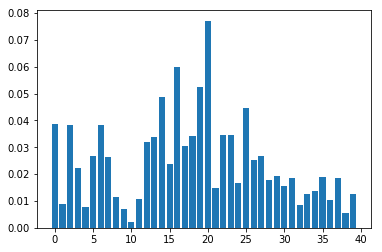

In [202]:
topic_coverage = [0 for topic in range(40)]
for article_topic in article_topics:
    for coverage in article_topic:
        topic_coverage[coverage[0]] += coverage[1]
topic_coverage = topic_coverage/sum(topic_coverage)

import matplotlib.pyplot as plt
plt.bar(range(40), topic_coverage)
# ldatopics[np.argsort(topic_coverage)[::-1][2]]

Now I will perform sentiment analysis

In [168]:
import nltk
from nltk.corpus import sentiwordnet as swn

In [203]:
def get_sentiment(word):
    mean_pos = 0
    mean_neg = 0
    mean_obj = 0
    score = 0
    bias = 0
    for similar_words in swn.senti_synsets(word):
        mean_pos += similar_words.pos_score()
        mean_neg += similar_words.neg_score()
        mean_obj += similar_words.obj_score()
    size = len(list(swn.senti_synsets(word)))
    if size != 0:
        mean_pos = mean_pos/size
        mean_neg = mean_neg/size
        mean_obj = mean_obj/size
        score = (mean_pos - mean_neg)*(1-mean_obj)
        bias = (mean_pos + mean_neg) * (1-mean_obj)
    return mean_pos, mean_neg, mean_obj, score, bias

In [189]:
ldatopics = ldamodel.show_topics(num_topics=-1, num_words=10000,formatted=False)
relevant_types = ['JJ', 'VB', 'RB'] #adjectives, verbs, adverbs
words = []
for word_and_prob in ldatopics[0][1]:
    word = word_and_prob[0]
    for word, word_type in nltk.pos_tag([word]):
        if word_type in relevant_types:
            words.append(word)
words

['new',
 'federal',
 'poor',
 'many',
 'american',
 'much',
 'get',
 'republican',
 'back',
 'make',
 'go',
 'say',
 'even',
 'take',
 'national',
 'economic',
 'come',
 'private',
 'fiscal',
 'first',
 'already',
 'major',
 'however',
 'next',
 'local',
 'nearly',
 'additional',
 'senior',
 'see',
 'well',
 'conservative',
 'important',
 'give',
 'actually',
 'instead',
 'leave',
 'rely',
 'good',
 'likely',
 'reduce',
 'former',
 'save',
 'current',
 'big',
 'military',
 'run',
 'social',
 'almost',
 'disabled',
 'significant',
 'next_year',
 'simply',
 'keep',
 'know',
 'still',
 'really',
 'improve',
 'basic',
 'several',
 'able',
 'overall',
 'yet',
 'little',
 'total',
 'large',
 'away',
 'low',
 'education_secretary',
 'long',
 'broad',
 'especially',
 'particularly',
 'financial',
 'currently',
 'rich',
 'roughly',
 'far',
 'tough',
 'annual',
 'domestic',
 'hard',
 'certain',
 'huge',
 'special',
 'alone',
 'never',
 'close',
 'different',
 'full',
 'true',
 'rural',
 'recentl

In [207]:
sentiment_of_words = dict()
for word in words:
    pos, neg, obj, score, bias = get_sentiment(word)
    if pos == 0 and neg == 0:
        pass
    else:
        sentiment_of_words[word] = [pos, neg, obj, score, bias]
words = list(sentiment_of_words.keys())
print(words[1], sentiment_of_words[words[1]])

poor [0.017857142857142856, 0.42857142857142855, 0.5535714285714286, -0.18335459183673466, 0.19929846938775508]


In [249]:
ldatopics[0][1]

[('budget', 0.02808199322163131),
 ('program', 0.021117763218661094),
 ('cut', 0.012072576486495304),
 ('billion', 0.011582132996364781),
 ('year', 0.0068781050401144853),
 ('spending', 0.0066952741695940812),
 ('plan', 0.0063517051789607299),
 ('state', 0.0063104265665915324),
 ('million', 0.0057563904756395877),
 ('funding', 0.0054106543170873312),
 ('new', 0.005259982387569721),
 ('people', 0.0051992865888466754),
 ('congress', 0.0051959130681390828),
 ('1', 0.0050486304868711408),
 ('money', 0.0048109342075945962),
 ('proposal', 0.0047559213715295005),
 ('social_security', 0.0046702953704584925),
 ('percent', 0.0046030923840488513),
 ('help', 0.0044968434992612109),
 ('work', 0.0044751783772880305),
 ('administration', 0.0044458228296268016),
 ('10', 0.0044438675118100394),
 ('fund', 0.0044372994898062628),
 ('white_house', 0.0044279324794290016),
 ('government', 0.0044072583087881321),
 ('federal', 0.004045994142384329),
 ('need', 0.0037933232929567066),
 ('benefit', 0.00376726365

In [261]:
sentiment_by_article_with_prob = []
for i, article_topic in enumerate(article_topics):
    print(i)
    sentiment_by_topic = dict()
    min_prob = 1
    for topic_and_prob in article_topic:
        topic = topic_and_prob[0]
        topic_prob = topic_and_prob[1]
        s_pos = 0
        s_neg = 0
        s_obj = 0
        s_score = 0
        s_bias = 0
        relevant_word_count = 0
        for words_and_probs in ldatopics[topic][1]:
            word = words_and_probs[0]
            if word in words and word in train_texts[i]:
                relevant_word_count += 1
                prob = words_and_probs[1]
                if prob < min_prob:
                    min_prob = prob
                pos, neg, obj, score, bias = sentiment_of_words[word]
                s_pos += pos
                s_neg += neg
                s_obj += obj
                s_score += score * prob #weight word depending on prob for that topic
                s_bias += bias * prob
        if relevant_word_count != 0:
            sentiment_by_topic[topic] = [topic_prob, min_prob, s_pos/relevant_word_count, s_neg/relevant_word_count, s_obj/relevant_word_count, s_score/relevant_word_count]
    sentiment_by_article_with_prob.append(sentiment_by_topic)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

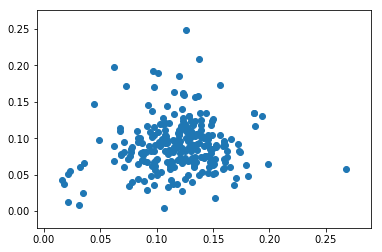

In [287]:
for topic in [27]:
    x = []
    y = []
    url = []
    for i, sentiment_by_topic in enumerate(sentiment_by_article_without_prob):
        if topic in sentiment_by_topic:
            if sentiment_by_topic[topic][0] > 0.1:
                min_prob = sentiment_by_topic[topic][1]
                x.append(sentiment_by_topic[topic][2])
                y.append(sentiment_by_topic[topic][3])
                url.append(df['url'][i])
    plt.scatter(x, y)

In [257]:
# print(sentiment_by_article[1])
# print(sentiment_by_article[3])
relevant_word_count

0

### LDA as LSI

One of the problem with LDA is that if we train it on a large number of topics, the topics get "lost" among the numbers. Let us see if we can dig out the best topics from the best LDA model we can produce. The function below can be used to control the quality of the LDA model we produce.

In [112]:
def ret_top_model():
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can see what the interpretability of the best topic is and keep
    evaluating the topic model until this threshold is crossed. 
    
    Returns:
    -------
    lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    chunksize = 10000
    passes = 1         # Was 20
    iterations = 50     # Was 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.
    num_topics = 40
    top_topics = [(0, 0)]
    
    while top_topics[0][1] < 0.70:
        print(top_topics[0][1])
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, \
                       passes=passes, eval_every=eval_every)
        coherence_values = {}
        for n, topic in lm.show_topics(num_topics=-1, formatted=False):
            topic = [word for word, _ in topic]
            cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary, window_size=10)
            coherence_values[n] = cm.get_coherence()
        top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)
    return lm, top_topics

In [113]:
lm, top_topics = ret_top_model()

0
0.43380315042


KeyboardInterrupt: 

In [ ]:
print(top_topics[:5])

### Inference
We can clearly see below that the first topic is about __cinema__, second is about __email malware__, third is about the land which was given back to the __Larrakia aboriginal community of Australia__ in 2000. Then there's one about __Australian cricket__. LDA as LSI has worked wonderfully in finding out the best topics from within LDA.

In [78]:
pprint([lm.show_topic(topicid) for topicid, c_v in top_topics[:10]])

[[(u'actor', 0.034688196735986693),
  (u'picture', 0.023163878883499418),
  (u'award', 0.023163878883499418),
  (u'comedy', 0.023163878883499418),
  (u'globe', 0.023163878883499418),
  (u'nomination', 0.023163878883499418),
  (u'actress', 0.023163878883499418),
  (u'film', 0.023163878883499418),
  (u'drama', 0.011639561031012149),
  (u'winner', 0.011639561031012149)],
 [(u'virus', 0.064292949289013482),
  (u'user', 0.048074573973209883),
  (u'computer', 0.040350900997751814),
  (u'company', 0.028173623478117912),
  (u'email', 0.022580226976870982),
  (u'worm', 0.020928236506996975),
  (u'attachment', 0.014534311779706417),
  (u'outlook', 0.01260706654637953),
  (u'software', 0.011909411409069969),
  (u'list', 0.0088116041533348403)],
 [(u'claim', 0.0096511365969504694),
  (u'agreement', 0.0082836950379963047),
  (u'hectare', 0.0077564979304569235),
  (u'larrakia', 0.0065928813973845394),
  (u'rosebury', 0.006086042494624749),
  (u'term', 0.004880655853124416),
  (u'region', 0.004786636

In [98]:
lda_lsi_topics = [[word for word, prob in lm.show_topic(topicid)] for topicid, c_v in top_topics]

### Evaluating all the topic models
Any topic model which can come up with topic terms can be plugged into the coherence pipeline. You can even plug in an [NMF topic model](http://derekgreene.com/nmf-topic/) created with scikit-learn.

In [99]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]

hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]

ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

lmtopics = [[word for word, prob in topic] for topicid, topic in lmtopics]

In [100]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_coherence = CoherenceModel(topics=ldatopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lm_coherence = CoherenceModel(topics=lmtopics, texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

lda_lsi_coherence = CoherenceModel(topics=lda_lsi_topics[:10], texts=train_texts, dictionary=dictionary, window_size=10).get_coherence()

In [101]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

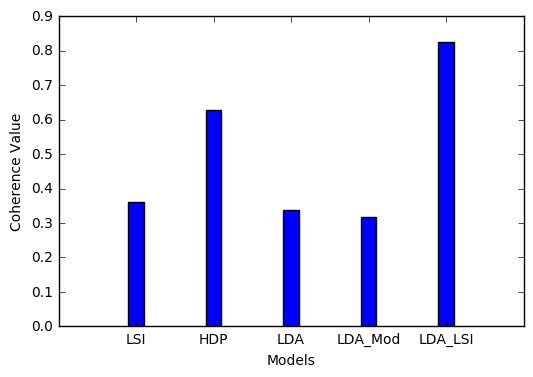

In [102]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_Mod', 'LDA_LSI'])

### Customizing the topic coherence measure
Till now we only used the `c_v` coherence measure. There are others such as `u_mass`, `c_uci`, `c_npmi`. All of these calculate coherence in a different way. `c_v` is found to be most in line with human ratings but can be much slower than `u_mass` since it uses a sliding window over the texts.

### Making your own coherence measure
Let's modify `c_uci` to use `s_one_pre` instead of `s_one_one` segmentation

In [47]:
from gensim.topic_coherence import (segmentation, probability_estimation,
                                    direct_confirmation_measure, indirect_confirmation_measure,
                                    aggregation)
from gensim.matutils import argsort
from collections import namedtuple

In [48]:
make_pipeline = namedtuple('Coherence_Measure', 'seg, prob, conf, aggr')

In [49]:
measure = make_pipeline(segmentation.s_one_one,
                        probability_estimation.p_boolean_sliding_window,
                        direct_confirmation_measure.log_ratio_measure,
                        aggregation.arithmetic_mean)

To get topics out of the topic model:

In [50]:
topics = []
for topic in lm.state.get_lambda():
    bestn = argsort(topic, topn=10, reverse=True)
topics.append(bestn)

__Step 1__: Segmentation

In [51]:
# Perform segmentation
segmented_topics = measure.seg(topics)

__Step 2__: Probability estimation

In [52]:
# Since this is a window-based coherence measure we will perform window based prob estimation
per_topic_postings, num_windows = measure.prob(texts=train_texts, segmented_topics=segmented_topics,
                                               dictionary=dictionary, window_size=2)

__Step 3__: Confirmation Measure

In [53]:
confirmed_measures = measure.conf(segmented_topics, per_topic_postings, num_windows, normalize=False)

__Step 4__: Aggregation

In [54]:
print(measure.aggr(confirmed_measures))

-11.2873225334


# How this topic model can be used further
The best topic model here can be used as a standalone for news article classification. However a topic model can also be used as a dimensionality reduction algorithm to feed into a classifier. A good topic model should be able to extract the signal from the noise efficiently, hence improving the performance of the classifier.